In [1]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import pandas as pd

c:\Users\caste\anaconda3\envs\pytochCuda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carga de datos

In [2]:
df = pd.read_csv('data/Finaltrain.csv')
df = df.sample(frac=1).reset_index(drop=True)
train_data = df[:int(0.8*len(df))]
test_data = df[int(0.8*len(df)):]

train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)


In [3]:
train_data.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_length,word_count,number_count,punctuation_count,stopword_count
0,29f2ca5ab097,814d6b,the expirement ended because jones felt that i...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave ex...,329,59,3,6,31
1,3271438e6fc4,39c16e,"An ideal tragedy, as described by Aristotle, n...",0.857053,0.787445,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to ...,481,86,0,12,33
2,ec78b3af9495,ebad26,They would rub chemicals or add some pickle in...,0.205683,0.380538,Summarize the various ways the factory would u...,Excerpt from The Jungle,With one member trimming beef ...,372,70,1,9,28
3,e390a4c8fcd1,ebad26,"Since the meat was spoiled, it let out an awfu...",0.702059,0.667072,Summarize the various ways the factory would u...,Excerpt from The Jungle,With one member trimming beef ...,736,137,0,20,65
4,09b083bb3af8,ebad26,use chemicals to cover the smell of spoiledThe...,-1.033882,-1.086703,Summarize the various ways the factory would u...,Excerpt from The Jungle,With one member trimming beef ...,214,42,0,3,20


In [4]:
train_data['text'].tolist()

['the expirement ended because jones felt that it was getting  out of  control, since the discipline and loyalty was outstanding. he decided to announce the third wave was apart of a nationwide movement, but told them it was an expirement. the expirement had "taken a life of its own" and it started with 30 students to 43 then 200',
 'An ideal tragedy, as described by Aristotle, needs three major components. The first being a protagonist neither good nor bad. He must be relatable to let the audience create their own image of him. Second, the main character must have a downfall based on a human error made within the play. Third, it should have one true plot, never straying from the main story. It has been proven that having more than one plot tends to lead toward a more comedy-like story than a true tragedy.',
 'They would rub chemicals or add some pickle in the meat to make it smell better. They wouldn\'t remove rats or anything that fell in so they would just label the meat "special" a

### Uso de BertTokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer.batch_encode_plus(
    train_data['text'].tolist(),
    truncation=True,
    padding=True
)

test_encodings = tokenizer.batch_encode_plus(
    test_data['text'].tolist(),
    truncation=True,
    padding=True
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_data['content'].tolist()),
    torch.tensor(train_data['wording'].tolist())
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask'])
)


### Clase BERTModel

In [6]:
class BERTModel(nn.Module):
  def __init__(self):
      super(BERTModel, self).__init__()
      self.bert = BertModel.from_pretrained('bert-base-uncased')

      self.dropout = nn.Dropout(0.1)
      self.linear1 = nn.Linear(768, 256)
      self.linear2 = nn.Linear(256, 2)

  def forward(self, input_ids, attention_mask):
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output
      pooled_output = self.dropout(pooled_output)
      output = self.linear1(pooled_output)
      output = nn.ReLU()(output)
      output = self.linear2(output)
      return output

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = BERTModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

cuda


In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

### Separación de datos de entrenamiento y validación

In [9]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Creating validation loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

### Entrenamiento del modelo

In [10]:
history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': [], 'mse': [], 'val_mse': []}

model.train()
for epoch in range(5):
    running_loss = 0.0
    running_mae = 0.0
    running_mse = 0.0
    
    for step, (input_ids, attention_mask, content, wording) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        content = content.to(device)
        wording = wording.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = (criterion(outputs[:, 0], content) + criterion(outputs[:, 1], wording))
        loss.backward()
        optimizer.step()

        mae = torch.mean(torch.abs(outputs[:, 0] - content) + torch.abs(outputs[:, 1] - wording)).item()
        mse = torch.mean((outputs[:, 0] - content) ** 2 + (outputs[:, 1] - wording) ** 2).item()

        running_loss += loss.item()
        running_mae += mae
        running_mse += mse

    epoch_loss = running_loss / len(train_loader)
    epoch_mae = running_mae / len(train_loader)
    epoch_mse = running_mse / len(train_loader)

    history['loss'].append(epoch_loss)
    history['mae'].append(epoch_mae)
    history['mse'].append(epoch_mse)

    print(f"Epoch {epoch+1} Loss: {epoch_loss}, MAE: {epoch_mae}, MSE: {epoch_mse}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        for val_step, (input_ids, attention_mask, content, wording) in enumerate(val_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            content = content.to(device)
            wording = wording.to(device)

            val_outputs = model(input_ids, attention_mask)
            val_loss += (criterion(val_outputs[:, 0], content) + criterion(val_outputs[:, 1], wording)).item()
            val_mae += torch.mean(torch.abs(val_outputs[:, 0] - content) + torch.abs(val_outputs[:, 1] - wording)).item()
            val_mse += torch.mean((val_outputs[:, 0] - content) ** 2 + (val_outputs[:, 1] - wording) ** 2).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae = val_mae / len(val_loader)
        avg_val_mse = val_mse / len(val_loader)

        history['val_loss'].append(avg_val_loss)
        history['val_mae'].append(avg_val_mae)
        history['val_mse'].append(avg_val_mse)

        print(f"Validation Loss: {avg_val_loss}, Validation MAE: {avg_val_mae}, Validation MSE: {avg_val_mse}")
    
    model.train()

c:\Users\caste\anaconda3\envs\pytochCuda3\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1 Loss: 1.0031116473226493, MAE: 1.0777750714243621, MSE: 1.0031116441265786
Validation Loss: 0.6585462991562154, Validation MAE: 0.8708349184857475, Validation MSE: 0.6585462979144521
Epoch 2 Loss: 0.5277635045038293, MAE: 0.7813516576310054, MSE: 0.5277635049604108
Validation Loss: 0.4723122217175033, Validation MAE: 0.7390961166885164, Validation MSE: 0.47231221778525245
Epoch 3 Loss: 0.42911155181508875, MAE: 0.7014418698452973, MSE: 0.4291115537244297
Validation Loss: 0.31416703532967305, Validation MAE: 0.6007776570816835, Validation MSE: 0.31416703367398846
Epoch 4 Loss: 0.3415726372832043, MAE: 0.6362732945212415, MSE: 0.34157263651531716
Validation Loss: 0.2475329799991515, Validation MAE: 0.5437849288185438, Validation MSE: 0.24753297782606548
Epoch 5 Loss: 0.28952808819275383, MAE: 0.588484742764311, MSE: 0.2895280887946113
Validation Loss: 0.24549474753439426, Validation MAE: 0.5469857243200144, Validation MSE: 0.24549474691351256


### Resultados

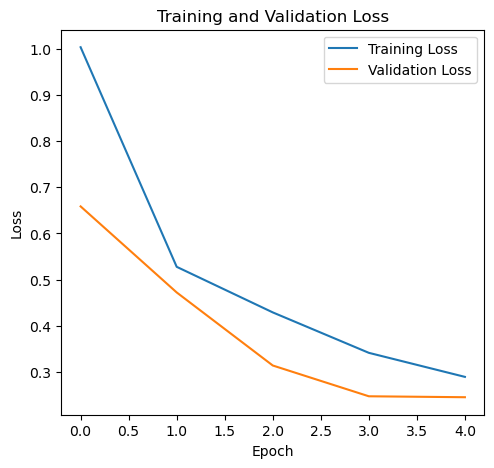

In [11]:
import matplotlib.pyplot as plt
import torch

loss = [l.cpu().numpy() if isinstance(l, torch.Tensor) else l for l in history['loss']]
val_loss = [vl.cpu().numpy() if isinstance(vl, torch.Tensor) else vl for vl in history['val_loss']]

# Plotting the results
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

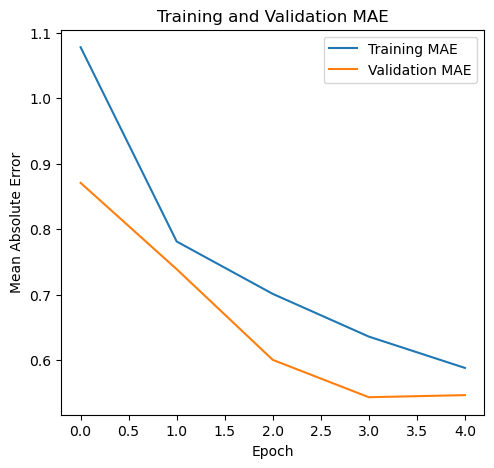

In [12]:
# MAE plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

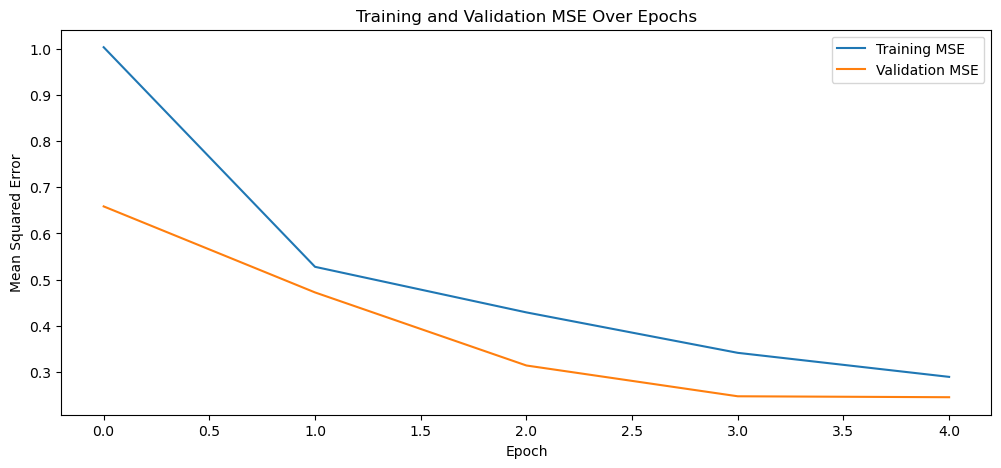

In [13]:
# Graficar el MSE para entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.plot(history['mse'], label='Training MSE')
plt.plot(history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE Over Epochs')
plt.legend()
plt.show()

In [14]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
model.eval()
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())

In [16]:
submission_df = pd.DataFrame({
    'student_id': test_data['student_id'],
    'content': [pred[0] for pred in predictions],
    'wording': [pred[1] for pred in predictions]
})

submission_df.to_csv('submission.csv', index=False)

In [17]:
submission_df

,student_id,content,wording
5732,4d67a6099fc8,0.214666,0.423596
5733,80997f2aa0ae,0.221711,0.737314
5734,d0bb89dfbbc9,0.457608,0.993950
5735,ef31ec70f4bc,-1.305126,-1.235027
5736,ac88fd43163e,-1.141485,-1.555570
...,...,...,...
7160,b6039c21104b,-0.645489,0.101622
7161,014641297f63,-0.968407,-0.831125
7162,11ab2f8cc682,1.042537,0.785157
7163,3dfba4d9eef3,-0.889260,-1.285126


In [18]:
from sklearn.metrics import mean_squared_error
submission_df = pd.read_csv('submission.csv')

mean_squared_error(test_data['content'], submission_df['content']), mean_squared_error(test_data['wording'], submission_df['wording'])

from sklearn.metrics import r2_score

r2_score(test_data['content'], submission_df['content']), r2_score(test_data['wording'], submission_df['wording'])


from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_data['content'], submission_df['content']), mean_absolute_error(test_data['wording'], submission_df['wording'])

print("MSE wording: ", mean_squared_error(test_data['wording'], submission_df['wording']))
print("MSE content: ", mean_squared_error(test_data['content'], submission_df['content']))
print("R2 wording: ", r2_score(test_data['wording'], submission_df['wording']))
print("R2 content: ", r2_score(test_data['content'], submission_df['content']))
print("MAE wording: ", mean_absolute_error(test_data['wording'], submission_df['wording']))
print("MAE content: ", mean_absolute_error(test_data['content'], submission_df['content']))

MSE wording:  0.34005523344032434
MSE content:  0.1824984066237707
R2 wording:  0.6492004280955666
R2 content:  0.823879514540588
MAE wording:  0.44079072370250977
MAE content:  0.3245784034695253


In [19]:
torch.save(model.state_dict(), './models/bert.pth')

In [23]:
# cargar el modelo .pth
pruebas = BERTModel()
pruebas.load_state_dict(torch.load('./models/bert.pth'))

C:\Users\caste\AppData\Local\Temp\ipykernel_16536\4090919026.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruebas.load_state_dict(torch.load('./models/bert.pth'))


<All keys matched successfully>

In [24]:
pruebas.eval()

BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [40]:
# evaluar pruebas con el test_loader
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = pruebas(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())

submission_df = pd.DataFrame({
    'student_id': test_data['student_id'],
    'content': [pred[0] for pred in predictions],
    'wording': [pred[1] for pred in predictions]
})

submission_df


,student_id,content,wording
5732,4e4fee9473e7,-1.247132,-1.478113
5733,2cc3efadc27e,-1.298066,-1.578533
5734,167a2ec7b78b,-1.190603,-1.274941
5735,77e05f8aa4aa,0.141618,0.146317
5736,63e73582ab0e,-1.343732,-1.631536
...,...,...,...
7160,d5f6cae267a4,-1.358836,-1.673710
7161,2aef0f0f01d9,-0.467022,-1.377712
7162,1fa7b128af81,-0.791339,-0.699829
7163,283e9a79445b,0.209526,0.175329
